# Multiple timeseries aproaches

Problems discription:
1. Many timeseries  from 1k to 100k
2. Hierarchy between timeseries
3. Lot of time for training and predictions

Aproaches for problems solving:
1. Use one model for yeach series (pros: customization model for each series, cons: need different model tunning for 
2. Train one model for all sereis (pros: simplicity, cons: not adequate models for different 
3. Group/clusterize series  and implement models on group, or 

Difficulties:
1. Different form of ts (sparse data, intermittent, changepoints leaps, etc)
2. Not equal importance of timeseries
3. Different frequency importance (for some - days,  for other month or quarter)


Aproaches for difficulties solving:
1. Classify/clusterize ts by nature
2. Apply for each ts best model

Type of forecasts model:
1. Regressions
2. Bayesian models
3. Econometrics models
4. Adaptive models

Quality scores difficulties:
1. Anadequte forecasts (too large, or negative - need find criteria for detecting sereis with problems)
2. Complex metrics for many series don't show which is more mistake

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.tsa.api import ExponentialSmoothing
import warnings

In [89]:
import sys
metric_path = '../../frameworks/time_series_signals_sound'
sys.path.append(metric_path)

In [90]:
from metrics import timeseries_metrics

In [3]:
data = pd.read_pickle('/home/mrmopoz/jupyter_notebooks/work_projects/forecast/11.01.2021/forecast_data_2021-03-26.pckl')

In [4]:
data.head()

,id,ds,name_ru,customer,region_from,bar_code_type,count_rpo,sum_mass_kg,mean_mass
0,basildon v etoe rua->ASOS->казань->EMS->,2019-03-24,basildon v etoe rua,ASOS,казань,EMS,27,58.44,2.087143
1,basildon v etoe rua->ASOS->казань->EMS->,2019-03-25,basildon v etoe rua,ASOS,казань,EMS,4,8.83,1.766000
2,basildon v etoe rua->ASOS->казань->EMS->,2019-04-10,basildon v etoe rua,ASOS,казань,EMS,15,33.54,2.096250
3,basildon v etoe rua->ASOS->казань->EMS->,2019-04-11,basildon v etoe rua,ASOS,казань,EMS,12,28.31,2.177692
4,basildon v etoe rua->ASOS->казань->EMS->,2019-04-12,basildon v etoe rua,ASOS,казань,EMS,5,11.46,1.910000


In [42]:
pivot_data = data.pivot(index='ds', columns='id', values='sum_mass_kg').fillna(0)

In [38]:
pivot_data.tail()

id,basildon v etoe rua->ASOS->казань->EMS->,basildon v etoe rua->ASOS->казань->RM->,basildon v etoe rua->ASOS->москва->EMS->,basildon v etoe rua->ASOS->москва->RM->,basildon v etoe rua->ASOS->москва->Посылки->,basildon v etoe rua->ASOS->санкт-петербург->EMS->,basildon v etoe rua->ASOS->санкт-петербург->RM->,basildon v etoe rua->ASOS->санкт-петербург->Посылки->,basildon v etoe rua->Alfaparcel->москва->EMS->,basildon v etoe rua->Alfaparcel->санкт-петербург->EMS->,...,япония->ИПА->владивосток->Посылка->,япония->ИПА->казань->EMS->,япония->ИПА->казань->RM->,япония->ИПА->москва->EMS->,япония->ИПА->москва->NRM->,япония->ИПА->москва->RM->,япония->ИПА->москва->Посылка->,япония->ИПА->оренбург->RM->,япония->ИПА->санкт-петербург->EMS->,япония->ИПА->санкт-петербург->RM->
ds,,,,,,,,,,,,,,,,,,,,,
2021-03-21,0.0,0.0,0.0,11621.566,2192.37,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22,0.0,0.0,0.0,1637.578,2803.97,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-23,0.0,0.0,0.0,5128.392,2463.32,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-24,0.0,0.0,0.0,6900.633,1796.42,0.0,0.0,0.0,0.0,0.0,...,2719.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-25,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


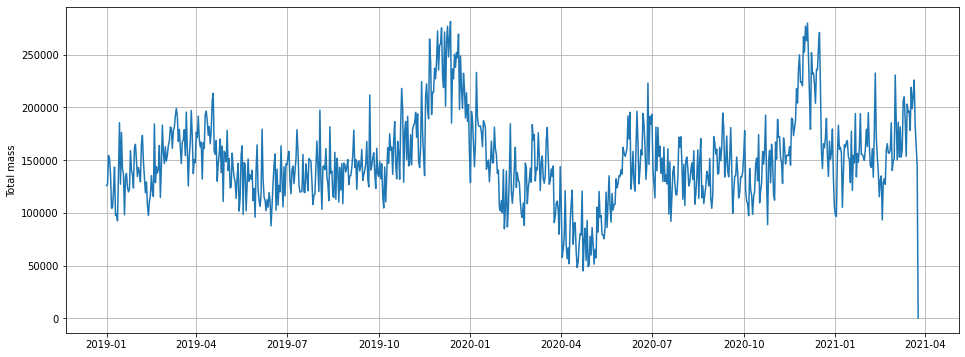

In [48]:
plt.figure(figsize=(16,6))
plt.plot(pivot_data.sum(axis=1))
plt.ylabel('Total mass')
plt.grid()
plt.show()

### Last few days not full remove it from data

In [61]:
pivot_data = pivot_data.loc[:'2021-03-21', :]

In [66]:
pivot_data.tail()

id,basildon v etoe rua->ASOS->казань->EMS->,basildon v etoe rua->ASOS->казань->RM->,basildon v etoe rua->ASOS->москва->EMS->,basildon v etoe rua->ASOS->москва->RM->,basildon v etoe rua->ASOS->москва->Посылки->,basildon v etoe rua->ASOS->санкт-петербург->EMS->,basildon v etoe rua->ASOS->санкт-петербург->RM->,basildon v etoe rua->ASOS->санкт-петербург->Посылки->,basildon v etoe rua->Alfaparcel->москва->EMS->,basildon v etoe rua->Alfaparcel->санкт-петербург->EMS->,...,япония->ИПА->владивосток->Посылка->,япония->ИПА->казань->EMS->,япония->ИПА->казань->RM->,япония->ИПА->москва->EMS->,япония->ИПА->москва->NRM->,япония->ИПА->москва->RM->,япония->ИПА->москва->Посылка->,япония->ИПА->оренбург->RM->,япония->ИПА->санкт-петербург->EMS->,япония->ИПА->санкт-петербург->RM->
ds,,,,,,,,,,,,,,,,,,,,,
2021-03-17,0.0,0.0,0.0,9271.600,1477.64,0.0,0.0,0.0,0.0,0.0,...,14.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-18,0.0,0.0,0.0,8869.111,3544.08,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-19,0.0,0.0,0.0,8249.790,1931.83,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-20,0.0,0.0,0.0,11478.853,2302.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-21,0.0,0.0,0.0,11621.566,2192.37,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


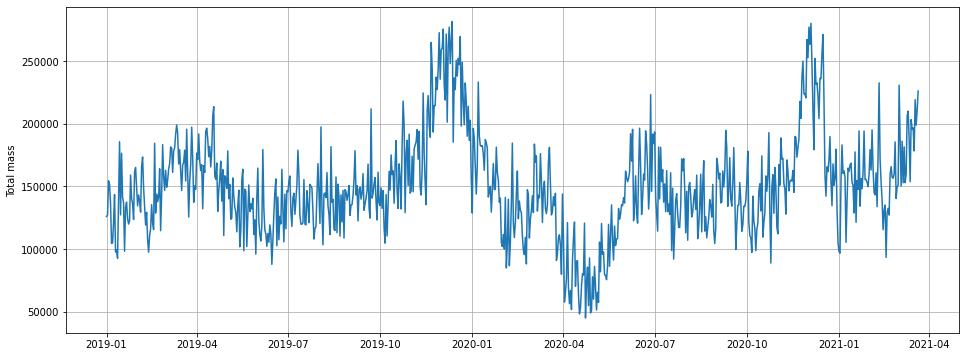

In [63]:
plt.figure(figsize=(16,6))
plt.plot(pivot_data.sum(axis=1))
plt.ylabel('Total mass')
plt.grid()
plt.show()

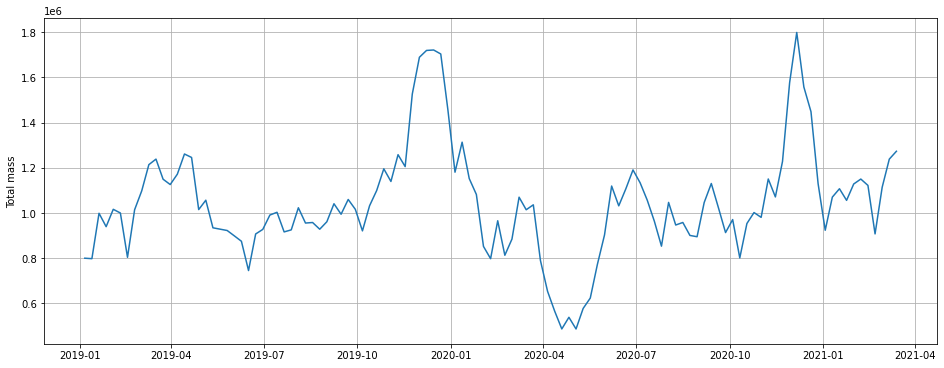

In [64]:
plt.figure(figsize=(16,6))
plt.plot(pivot_data.sum(axis=1).resample('W').sum()[:-1])
plt.grid()
plt.ylabel('Total mass')
plt.show()

## 0. Train-test split data

In [67]:
pivot_data.shape

(811, 1339)

In [71]:
train_data = pivot_data.loc[:'2020-12-31']
valid_data = pivot_data.loc['2021-01-01': '2021-02-28']
test_data  = pivot_data.loc['2021-03-01':]

## 1. Adaptive forecst

In [88]:
%%time
warnings.filterwarnings('ignore')
#day data
models = {}
for col in tqdm(train_data.columns):
    exp_sm_m = ExponentialSmoothing(train_data[col],
                                  trend="additive",
                                  seasonal="additive",
                                  seasonal_periods=365, freq='D').fit(optimized=True)
    models[col] = exp_sm_m
     


CPU times: user 19min 52s, sys: 0 ns, total: 19min 52s
Wall time: 19min 51s


In [98]:
errors = {}
for col in tqdm(train_data.columns):
    pred = models[col].forecast(len(valid_data))
    errors[col] = timeseries_metrics.mae(valid_data[col], pred)

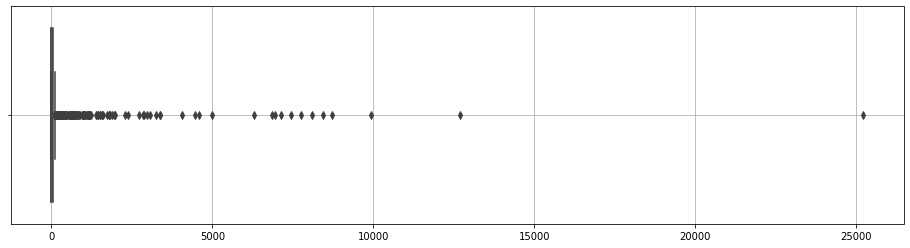

In [108]:
plt.figure(figsize=(16,4))
sns.boxplot(list(errors.values()))
plt.grid()

## Cluster series

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(pivot_data).T
std_data = pd.DataFrame(X, index=pivot_data.columns, columns=pivot_data.index)

In [ ]:
# find optimal cluster number
def plot_cluster_KMeans(data, max_cluster=20, random_state=10):
    range_n_clusters = range(2, max_cluster)
    clusters = []
    inertias = []
    silhouette = []
    for n_clusters in range_n_clusters:
        
        cluster = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = cluster.fit_predict(data)
        
        clusters.append(cluster)
        inertias.append(cluster.inertia_)
    
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette.append(silhouette_avg)
    
    fig, axs = plt.subplots(1,2, figsize=(16,4))
    axs[0].plot(range_n_clusters, inertias)
    axs[0].grid()
    axs[0].set_title('Inertia in depends of cluster numbers')
    axs[0].set_xlim([2,max_cluster])
    
    
    
    axs[1].plot(range_n_clusters, silhouette)
    axs[1].grid()
    axs[1].set_title('Silhouette score in depends of cluster numbers')
    axs[1].set_xlim([2,max_cluster])
    plt.show()
    return clusters


cluster = plot_cluster_KMeans(X)

In [ ]:
for c in cluster:
    print('Count of zone in cluster:')
    display(pd.Series(c.labels_).value_counts()) #normalize=True

In [ ]:
std_data['cluster_label'] = cluster[2].labels_